# Notes

**Team:** Solar Explorer

**Challenge:** Develop the Oracle of DSCOVR (https://www.spaceappschallenge.org/2023/challenges/develop-the-oracle-of-dscovr/?tab=details)

# Setup

In [ ]:
import pandas
import numpy
import seaborn
from matplotlib import pyplot as plt

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

from tensorflow import keras

# Kp Intensity Mapping

In [ ]:
# https://www.swpc.noaa.gov/products/planetary-k-index
# https://seetheaurora.com/kp-index-explained

def map_kp_intensity(kp):
    kp_rounded = round(kp)
    if kp_rounded <= 4:
        return 0 # storm
    else:
        return 1 # storm

# Load Data

**Planetary K-index (Kp) values**

Source: https://kp.gfz-potsdam.de/app/files/Kp_ap_since_1932.txt

In [ ]:
file_name_kp = 'kp_processed.csv'
kp_values = pandas.read_csv(file_name_kp)
kp_values

,YYY,MM,DD,Bsr,dB,Kp1,Kp2,Kp3,Kp4,Kp5,Kp6,Kp7,Kp8,F10.7obs,F10.7adj
0,2016,1,1,2488,19,6.000,5.333,5.000,3.333,1.667,1.000,2.000,1.667,98.4,95.1
1,2016,1,2,2488,20,3.000,2.333,3.000,2.333,2.333,1.667,1.667,1.333,100.0,96.6
2,2016,1,3,2488,21,0.333,1.667,2.000,0.667,1.333,2.333,1.667,2.667,101.9,98.5
3,2016,1,4,2488,22,0.333,1.667,1.667,0.667,0.667,2.000,1.667,0.667,95.3,92.2
4,2016,1,5,2488,23,0.333,1.000,1.000,1.667,1.000,2.000,2.333,2.000,95.2,92.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2674,2023,4,28,2587,20,3.333,4.000,2.667,2.667,3.333,4.000,3.000,3.333,149.8,151.8
2675,2023,4,29,2587,21,3.333,3.333,3.333,4.000,4.000,3.667,3.333,2.333,155.8,158.0
2676,2023,4,30,2587,22,3.000,3.000,3.000,1.333,1.667,1.667,0.667,1.333,153.5,155.8
2677,2023,5,1,2587,23,2.667,1.333,2.000,1.333,1.333,2.333,2.667,3.333,147.9,150.1


**Data from the Deep Space Climate Observatory (DSCOVR) PlasMAG instrument suite**

Source: https://www.spaceappschallenge.org/develop-the-oracle-of-dscovr-experimental-data-repository/

In [ ]:
file_names = ['dsc_fc_summed_spectra_2016_v01.csv',
              'dsc_fc_summed_spectra_2017_v01.csv',
              'dsc_fc_summed_spectra_2018_v01.csv',
              'dsc_fc_summed_spectra_2019_v01.csv',
              'dsc_fc_summed_spectra_2020_v01.csv',
              'dsc_fc_summed_spectra_2021_v01.csv',
              'dsc_fc_summed_spectra_2022_v01.csv',
              'dsc_fc_summed_spectra_2023_v01.csv',
              ]

In [ ]:
df_all = []

for file_name in file_names:
    df_temp = pandas.read_csv(file_name, delimiter = ',', parse_dates=[0], infer_datetime_format=True, na_values='0', header = None)
    df_all.append(df_temp)

df = pandas.concat(df_all, ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2016-01-01 00:00:00,6.83609,-3.37934,-12.920500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 00:01:00,6.76732,-3.30194,-12.996700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 00:02:00,6.39107,-2.61173,-13.327100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01 00:03:00,6.44897,-2.61525,-13.329900,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01 00:04:00,6.58758,-2.73082,-13.236100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277435,2023-05-02 23:55:00,4.33665,2.80127,0.954633,1.004790,0.231726,4.64757,0.626576,3.54595,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277436,2023-05-02 23:56:00,4.66778,2.10582,1.260660,0.781621,0.231726,5.97222,0.360648,3.39143,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277437,2023-05-02 23:57:00,4.28322,3.02154,0.927773,0.854185,0.231726,8.10454,2.025800,4.22000,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3277438,2023-05-02 23:58:00,4.31376,2.67727,1.723270,0.801559,0.231726,12.76210,2.818550,4.82242,0.301864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.drop_duplicates(subset=[0])
print('new df shape:', df.shape)

new df shape: (3265920, 54)


In [ ]:
del df_all
del df_temp

# Merge Kp Values with DSCOVR PlasMAG Measurements

In [ ]:
kp_values_new = pandas.DataFrame()
kp_values_new['DateTime'] = pandas.to_datetime(kp_values.rename(columns={'YYY': 'year', 'MM': 'month', 'DD': 'day'})[['year', 'month', 'day']])
kp_values_new['Kp'] = numpy.nan
kp_values_new = kp_values_new.loc[kp_values_new.index.repeat(8)].reset_index(drop=True) # repeat each date 8 times
kp_values_new

count = 0
for i in range(len(kp_values_new)):
    kp_values_new['DateTime'].iloc[i] = kp_values_new['DateTime'].iloc[i] + pandas.Timedelta(3*count, unit='H') # add hour
    kp_values_new['Kp'].iloc[i] = kp_values.iloc[int(numpy.floor(i/8)), 5+count] # get Kp value
    count = (count+1)%8

kp_values_new

<ipython-input-13-6f6950375f29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kp_values_new['DateTime'].iloc[i] = kp_values_new['DateTime'].iloc[i] + pandas.Timedelta(3*count, unit='H') # add hour
<ipython-input-13-6f6950375f29>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kp_values_new['Kp'].iloc[i] = kp_values.iloc[int(numpy.floor(i/8)), 5+count] # get Kp value


,DateTime,Kp
0,2016-01-01 00:00:00,6.000
1,2016-01-01 03:00:00,5.333
2,2016-01-01 06:00:00,5.000
3,2016-01-01 09:00:00,3.333
4,2016-01-01 12:00:00,1.667
...,...,...
21427,2023-05-02 09:00:00,2.667
21428,2023-05-02 12:00:00,1.000
21429,2023-05-02 15:00:00,1.000
21430,2023-05-02 18:00:00,1.667


In [ ]:
kp_values_new.describe()

,Kp
count,21432.000000
mean,1.618861
std,1.231716
min,0.000000
25%,0.667000
50%,1.333000
75%,2.333000
max,8.333000


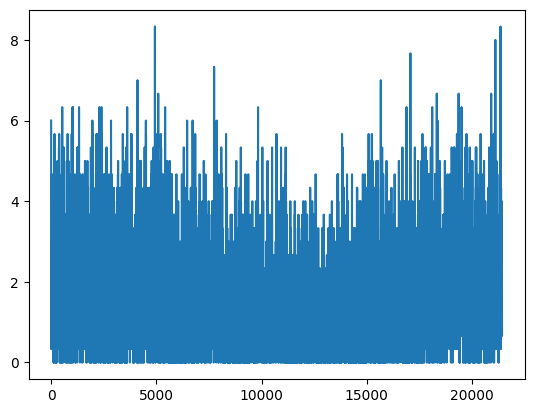

In [ ]:
kp_values_new['Kp'].plot();

In [ ]:
df = df.merge(kp_values_new, how='left', left_on=0, right_on='DateTime')
df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,DateTime,Kp
0,2016-01-01 00:00:00,6.83609,-3.37934,-12.920500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01,6.0
1,2016-01-01 00:01:00,6.76732,-3.30194,-12.996700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,2016-01-01 00:02:00,6.39107,-2.61173,-13.327100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,2016-01-01 00:03:00,6.44897,-2.61525,-13.329900,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,2016-01-01 00:04:00,6.58758,-2.73082,-13.236100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265915,2023-05-02 23:55:00,4.33665,2.80127,0.954633,1.004790,0.231726,4.64757,0.626576,3.54595,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3265916,2023-05-02 23:56:00,4.66778,2.10582,1.260660,0.781621,0.231726,5.97222,0.360648,3.39143,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3265917,2023-05-02 23:57:00,4.28322,3.02154,0.927773,0.854185,0.231726,8.10454,2.025800,4.22000,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3265918,2023-05-02 23:58:00,4.31376,2.67727,1.723270,0.801559,0.231726,12.76210,2.818550,4.82242,0.301864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


<ipython-input-17-0e1cfedc703f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

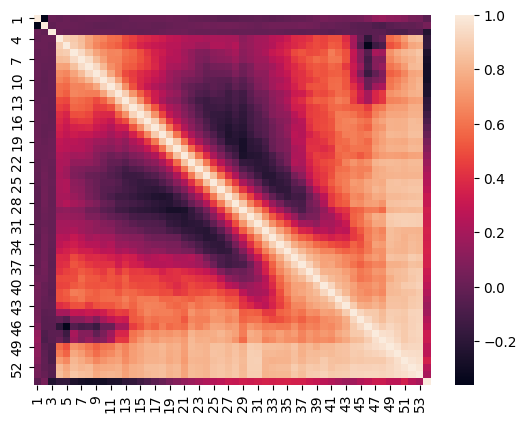

In [ ]:
corr = df.corr()
seaborn.heatmap(corr)

# Explore Null Values

In [ ]:
df.isna().sum()/len(df)

0           0.000000
1           0.005341
2           0.005341
3           0.005341
4           0.535438
5           0.516347
6           0.473960
7           0.446791
8           0.412615
9           0.386574
10          0.350117
11          0.321009
12          0.280897
13          0.260339
14          0.223558
15          0.208193
16          0.190213
17          0.169191
18          0.154578
19          0.144013
20          0.129725
21          0.129335
22          0.131792
23          0.158242
24          0.174250
25          0.227902
26          0.257716
27          0.305070
28          0.342318
29          0.400411
30          0.443732
31          0.514752
32          0.543588
33          0.619053
34          0.644199
35          0.675720
36          0.730243
37          0.761839
38          0.783661
39          0.831320
40          0.846186
41          0.895596
42          0.908677
43          0.925957
44          0.945059
45          0.959690
46          0.968323
47          0

# Get Rows That Have a Kp Value and Remove Columns With >25% Missing Values

In [ ]:
df_3_hour = df.dropna(subset=['Kp'])
df_3_hour['KpIntensity'] = numpy.nan
df_3_hour['Month'] = numpy.nan
for i in range(len(df_3_hour)):
    df_3_hour['KpIntensity'].iloc[i] = map_kp_intensity(df_3_hour['Kp'].iloc[i])
    df_3_hour['Month'].iloc[i] = df_3_hour['DateTime'].iloc[i].month
df_3_hour

<ipython-input-18-e13fe6f764b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3_hour['KpIntensity'] = numpy.nan
<ipython-input-18-e13fe6f764b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3_hour['Month'] = numpy.nan
<ipython-input-18-e13fe6f764b6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3_hour['KpI

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,DateTime,Kp,KpIntensity,Month
0,2016-01-01 00:00:00,6.83609,-3.379340,-12.920500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,6.000,1.0,1.0
180,2016-01-01 03:00:00,2.73868,-0.081683,-13.087800,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 03:00:00,5.333,1.0,1.0
360,2016-01-01 06:00:00,4.27908,-7.856530,-6.089070,142.838000,103.986000,130.149000,131.539000,125.032000,104.784000,...,130.631,149.299,155.784,134.033,160.265,145.54,2016-01-01 06:00:00,5.000,1.0,1.0
540,2016-01-01 09:00:00,7.27718,-7.189180,0.699289,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:00:00,3.333,0.0,1.0
720,2016-01-01 12:00:00,6.55048,-6.579680,-3.764000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 12:00:00,1.667,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265020,2023-05-02 09:00:00,4.44582,0.074414,-1.342450,1.404280,0.231726,0.761706,0.231726,0.231726,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-02 09:00:00,2.667,0.0,5.0
3265200,2023-05-02 12:00:00,4.05329,-0.609750,2.693050,1.196930,0.231726,0.429790,0.231726,0.231726,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-02 12:00:00,1.000,0.0,5.0
3265380,2023-05-02 15:00:00,3.60467,2.521510,1.767770,1.237600,0.231726,0.369987,0.231726,0.231726,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-02 15:00:00,1.000,0.0,5.0
3265560,2023-05-02 18:00:00,4.78423,0.161718,-1.606930,0.231726,0.231726,0.582688,5.535300,8.985620,0.231726,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-02 18:00:00,1.667,0.0,5.0


In [ ]:
numpy.unique(df_3_hour['KpIntensity'], return_counts=True)

(array([0., 1.]), array([17701,   443]))

<Axes: xlabel='Month', ylabel='Count'>

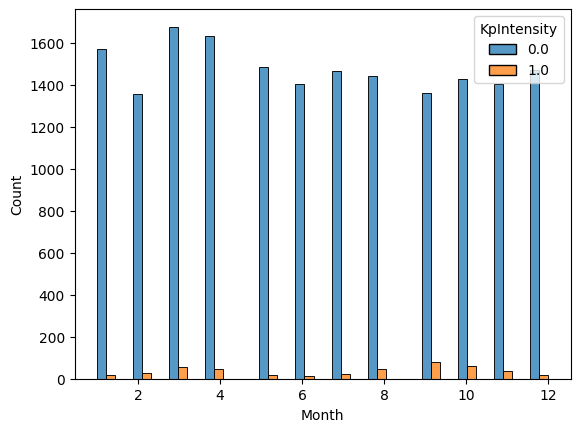

In [ ]:
seaborn.histplot(df_3_hour, x='Month', hue='KpIntensity', multiple='dodge')

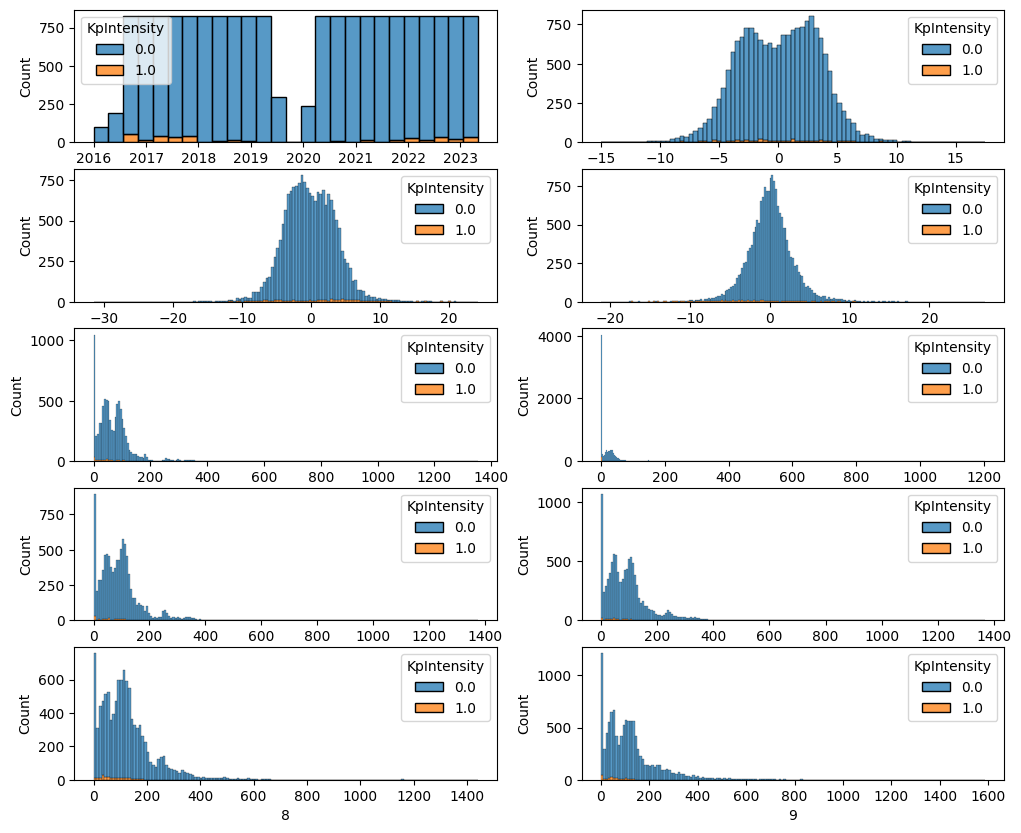

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,10))
axes = axes.flatten()
index = 0
for column in df_3_hour.columns[0:10]:
    seaborn.histplot(x=column, hue='KpIntensity', data=df_3_hour, ax=axes[index], multiple='stack')
    index+=1

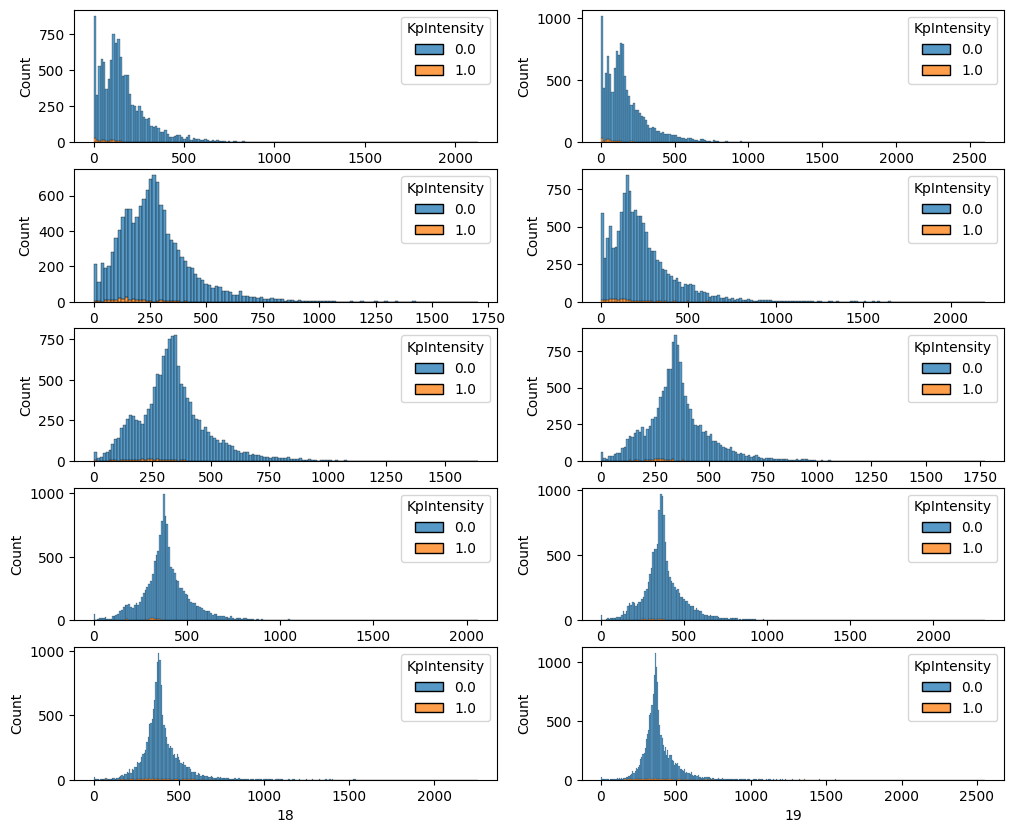

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,10))
axes = axes.flatten()
index = 0
for column in df_3_hour.columns[10:20]:
    seaborn.histplot(x=column, hue='KpIntensity', data=df_3_hour, ax=axes[index], multiple='stack')
    index+=1

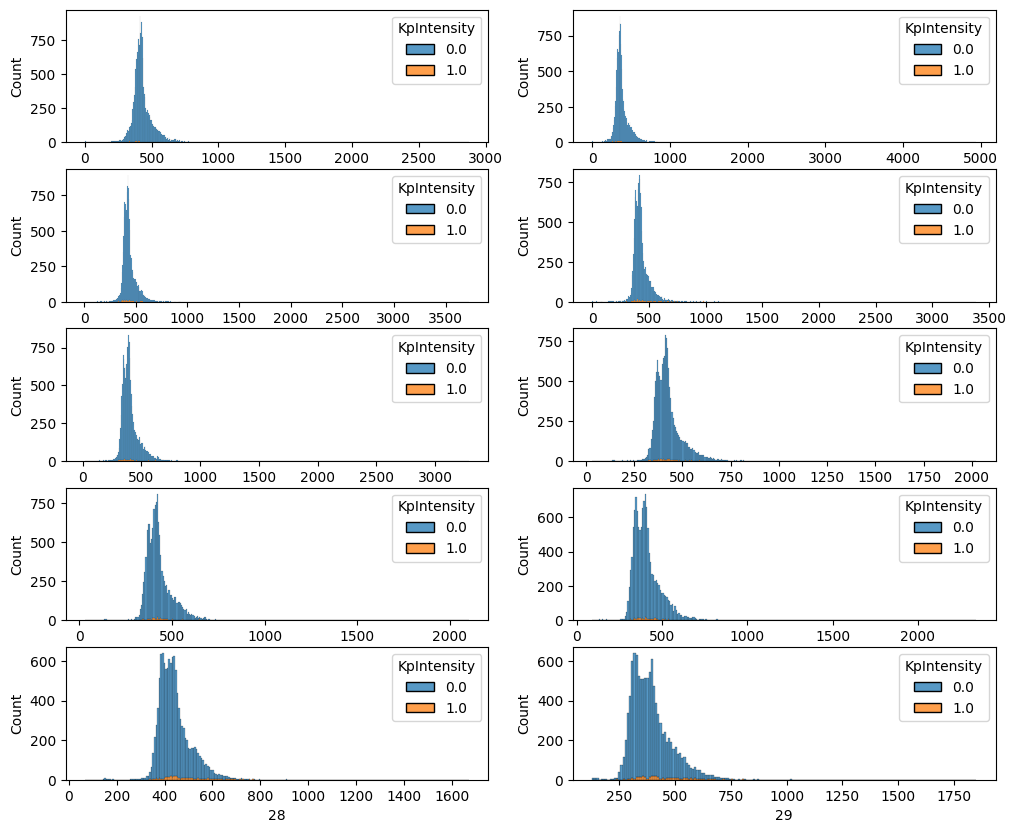

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,10))
axes = axes.flatten()
index = 0
for column in df_3_hour.columns[20:30]:
    seaborn.histplot(x=column, hue='KpIntensity', data=df_3_hour, ax=axes[index], multiple='stack')
    index+=1

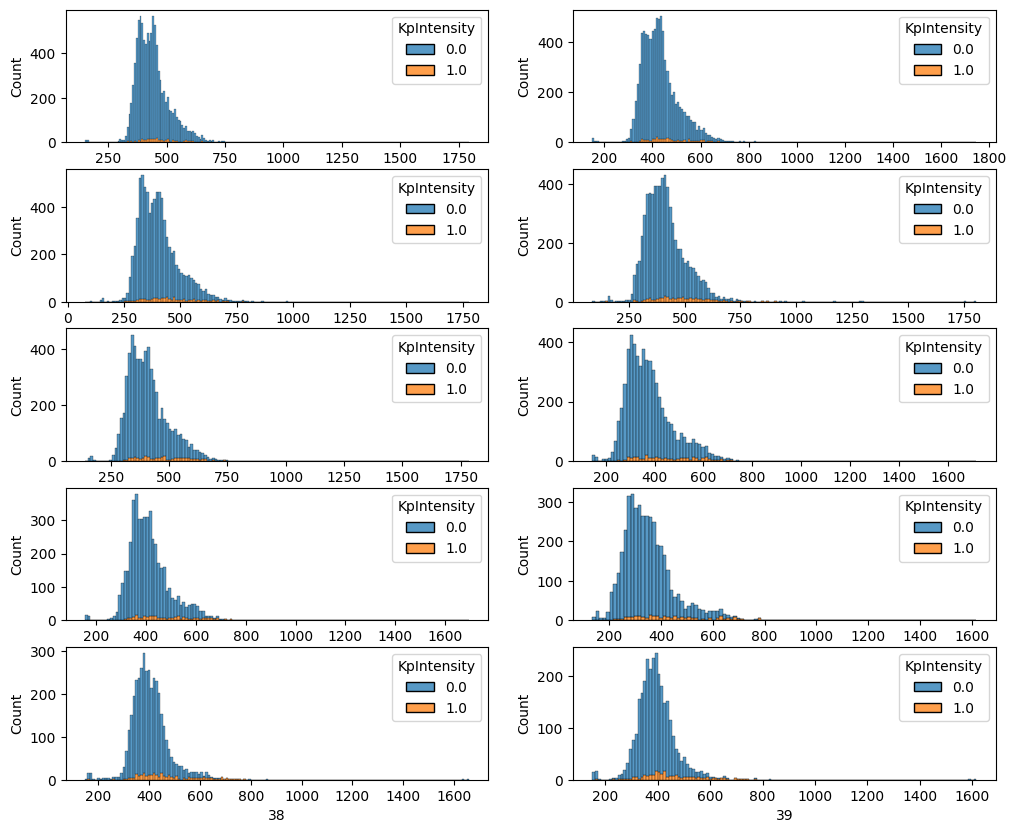

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,10))
axes = axes.flatten()
index = 0
for column in df_3_hour.columns[30:40]:
    seaborn.histplot(x=column, hue='KpIntensity', data=df_3_hour, ax=axes[index], multiple='stack')
    index+=1

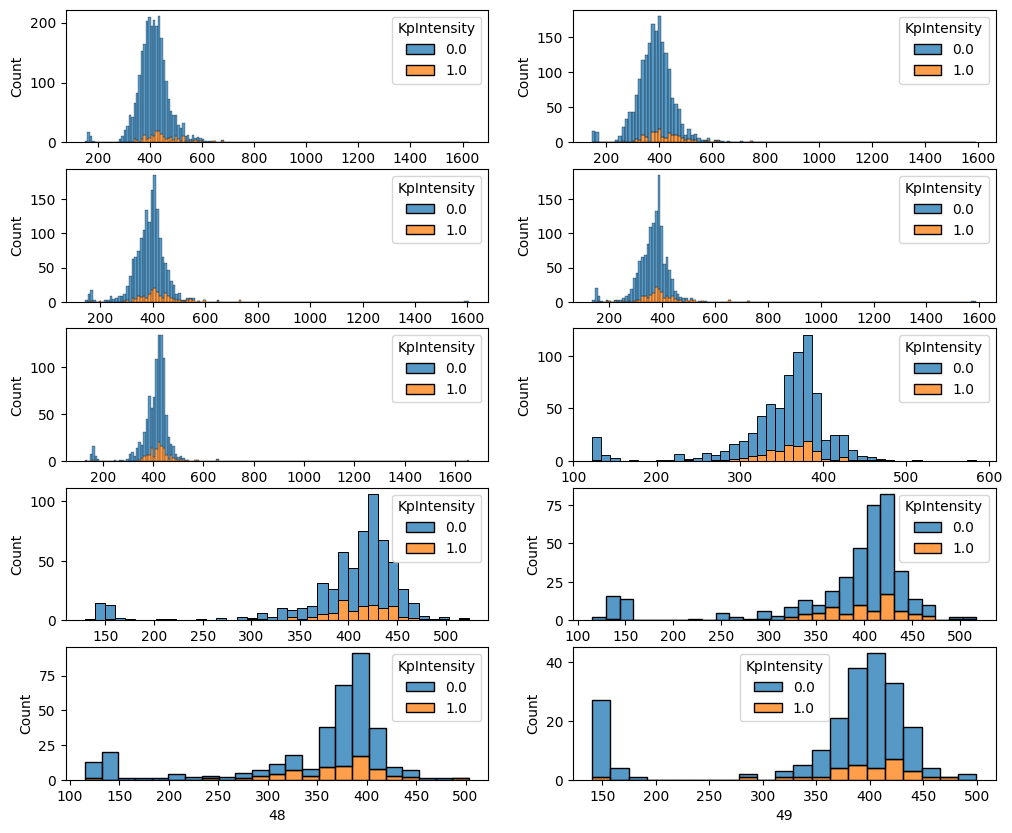

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,10))
axes = axes.flatten()
index = 0
for column in df_3_hour.columns[40:50]:
    seaborn.histplot(x=column, hue='KpIntensity', data=df_3_hour, ax=axes[index], multiple='stack')
    index+=1

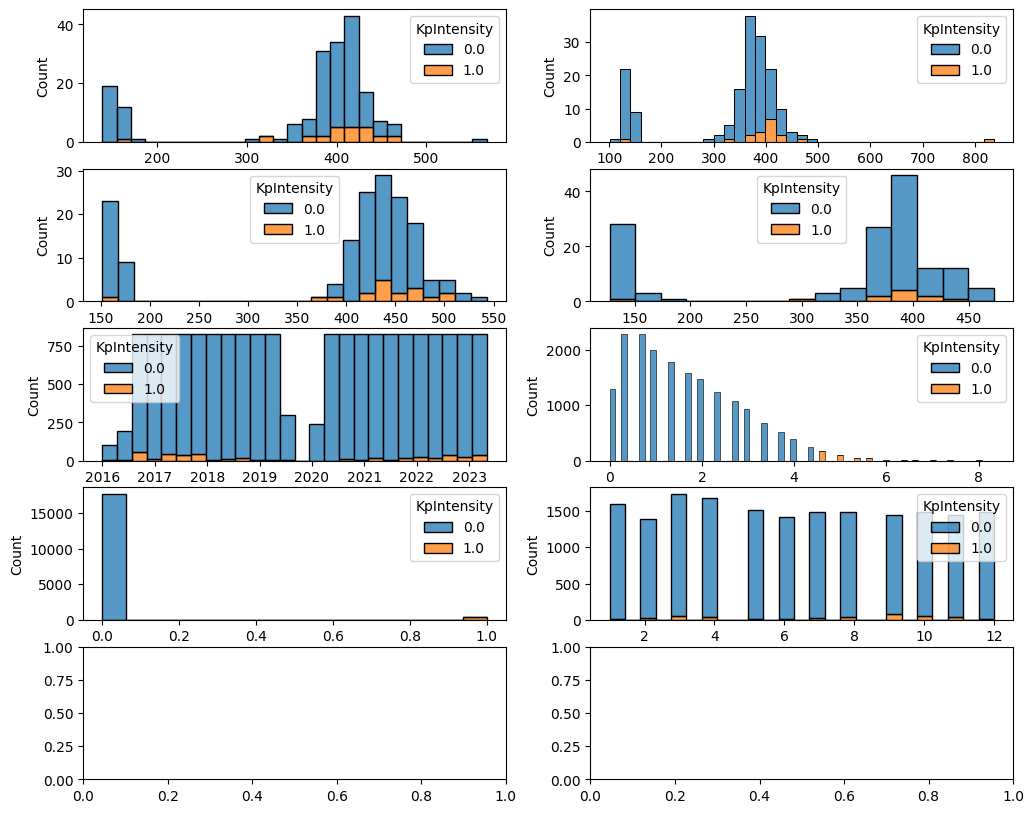

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,10))
axes = axes.flatten()
index = 0
for column in df_3_hour.columns[50:60]:
    seaborn.histplot(x=column, hue='KpIntensity', data=df_3_hour, ax=axes[index], multiple='stack')
    index+=1

In [ ]:
df_3_hour.isna().sum()/len(df_3_hour)

0              0.000000
1              0.004740
2              0.004740
3              0.004740
4              0.531911
5              0.513283
6              0.469687
7              0.442901
8              0.409061
9              0.382440
10             0.345569
11             0.316027
12             0.276620
13             0.256007
14             0.218860
15             0.203318
16             0.186122
17             0.164793
18             0.150739
19             0.139440
20             0.124118
21             0.124449
22             0.128031
23             0.155423
24             0.170690
25             0.225088
26             0.256063
27             0.301918
28             0.341049
29             0.399195
30             0.441799
31             0.513172
32             0.541556
33             0.617229
34             0.642857
35             0.673997
36             0.728946
37             0.761519
38             0.783289
39             0.831900
40             0.845789
41             0

In [ ]:
to_drop = list(range(4, 14))
to_drop.extend(range(26, 54))
df_3_hour = df_3_hour.drop(df_3_hour.columns[to_drop], axis=1)
df_3_hour

,0,1,2,3,14,15,16,17,18,19,20,21,22,23,24,25,DateTime,Kp,KpIntensity,Month
0,2016-01-01 00:00:00,6.83609,-3.379340,-12.920500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,6.000,1.0,1.0
180,2016-01-01 03:00:00,2.73868,-0.081683,-13.087800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 03:00:00,5.333,1.0,1.0
360,2016-01-01 06:00:00,4.27908,-7.856530,-6.089070,19.7798,8.37412,20.2644,26.9251,64.5492,99.6746,140.936,129.733,157.691,158.978,140.405,137.109,2016-01-01 06:00:00,5.000,1.0,1.0
540,2016-01-01 09:00:00,7.27718,-7.189180,0.699289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:00:00,3.333,0.0,1.0
720,2016-01-01 12:00:00,6.55048,-6.579680,-3.764000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 12:00:00,1.667,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265020,2023-05-02 09:00:00,4.44582,0.074414,-1.342450,92.4149,108.66800,161.2140,173.6250,225.8880,232.0600,327.659,285.680,389.474,394.208,372.174,407.756,2023-05-02 09:00:00,2.667,0.0,5.0
3265200,2023-05-02 12:00:00,4.05329,-0.609750,2.693050,80.6516,97.59520,149.7690,162.7140,207.4810,216.2720,320.495,282.773,388.748,395.003,374.182,409.702,2023-05-02 12:00:00,1.000,0.0,5.0
3265380,2023-05-02 15:00:00,3.60467,2.521510,1.767770,75.2690,91.13330,145.8730,159.6140,204.2090,212.0640,318.577,281.220,389.900,396.175,370.735,408.062,2023-05-02 15:00:00,1.000,0.0,5.0
3265560,2023-05-02 18:00:00,4.78423,0.161718,-1.606930,93.2916,73.50840,130.9930,172.5420,259.8380,251.7520,305.012,247.891,387.964,460.750,487.326,471.632,2023-05-02 18:00:00,1.667,0.0,5.0


In [ ]:
df = df.drop(df.columns[to_drop], axis=1)
df

,0,1,2,3,14,15,16,17,18,19,20,21,22,23,24,25,DateTime,Kp
0,2016-01-01 00:00:00,6.83609,-3.37934,-12.920500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01,6.0
1,2016-01-01 00:01:00,6.76732,-3.30194,-12.996700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,2016-01-01 00:02:00,6.39107,-2.61173,-13.327100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,2016-01-01 00:03:00,6.44897,-2.61525,-13.329900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,2016-01-01 00:04:00,6.58758,-2.73082,-13.236100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265915,2023-05-02 23:55:00,4.33665,2.80127,0.954633,99.0198,117.976,175.410,187.942,240.844,237.600,333.436,313.828,447.967,481.579,453.894,433.184,NaT,NaN
3265916,2023-05-02 23:56:00,4.66778,2.10582,1.260660,93.9480,115.332,173.454,186.995,234.211,230.288,329.340,317.064,448.558,475.164,444.662,424.518,NaT,NaN
3265917,2023-05-02 23:57:00,4.28322,3.02154,0.927773,85.2002,108.741,172.236,188.357,233.385,225.799,325.976,306.145,428.713,457.857,451.269,449.096,NaT,NaN
3265918,2023-05-02 23:58:00,4.31376,2.67727,1.723270,82.5026,104.572,172.318,197.369,245.184,225.311,314.211,295.210,430.938,465.910,460.685,450.283,NaT,NaN


# Get Previous Measurements and Kp Values From -15 to -3 Hours

In [ ]:
X_now = numpy.empty((len(df_3_hour)-3, 720, 15))
y_next = numpy.empty(len(df_3_hour)-3)
y_now = numpy.empty(len(df_3_hour)-3)
y_prev_1 = numpy.empty(len(df_3_hour)-3)
y_prev_2 = numpy.empty(len(df_3_hour)-3)
y_prev_3 = numpy.empty(len(df_3_hour)-3)

time = pandas.Timestamp('2016-01-01 00:00:00')
to_remove = []
for i in range(len(X_now)):
    kp_intensity_next = df_3_hour[df_3_hour['DateTime'] == time + pandas.Timedelta(15, unit='H')]['KpIntensity']
    if len(kp_intensity_next) != 0:
        y_next[i] = kp_intensity_next

        kp_intensity_now = df_3_hour[df_3_hour['DateTime'] == time + pandas.Timedelta(12, unit='H')]['KpIntensity']
        if len(kp_intensity_now) != 0:
            y_now[i] = kp_intensity_now

            kp_intensity_prev_1 = df_3_hour[df_3_hour['DateTime'] == time + pandas.Timedelta(3, unit='H')]['KpIntensity']
            if len(kp_intensity_prev_1) != 0:
                y_prev_1[i] = kp_intensity_prev_1

                kp_intensity_prev_2 = df_3_hour[df_3_hour['DateTime'] == time + pandas.Timedelta(6, unit='H')]['KpIntensity']
                if len(kp_intensity_prev_2) != 0:
                    y_prev_2[i] = kp_intensity_prev_2

                    kp_intensity_prev_3 = df_3_hour[df_3_hour['DateTime'] == time + pandas.Timedelta(9, unit='H')]['KpIntensity']
                    if len(kp_intensity_prev_3) != 0:
                        y_prev_3[i] = kp_intensity_prev_3

                        subset = df[(df.iloc[:,0] > time) & (df.iloc[:,0] <= time + pandas.Timedelta(12, unit='H'))].iloc[:,1:16]
                        if len(subset) != 720:
                            to_remove.append(i)
                        else:
                            X_now[i] = subset
                    else:
                        to_remove.append(i)
                else:
                    to_remove.append(i)
            else:
                to_remove.append(i)
        else:
            to_remove.append(i)
    else:
        to_remove.append(i)
    time = time + pandas.Timedelta(3, unit='H')

In [ ]:
to_remove = list(dict.fromkeys(to_remove)) # remove duplicates
X_now = numpy.delete(X_now, to_remove, axis=0)
y_now = numpy.delete(y_now, to_remove, axis=0)
y_next = numpy.delete(y_next, to_remove, axis=0)
y_prev_1 = numpy.delete(y_prev_1, to_remove, axis=0)
y_prev_2 = numpy.delete(y_prev_2, to_remove, axis=0)
y_prev_3 = numpy.delete(y_prev_3, to_remove, axis=0)

In [ ]:
for i in range(len(X_now)):
    for j in range(X_now.shape[2]):
        if numpy.count_nonzero(numpy.isnan(X_now[i,:,j])) > 720/2: # more than 50% null
            X_now[i,:,j] = numpy.nan_to_num(X_now[i,:,j])
        else:
            X_now[i,:,j] = pandas.Series(X_now[i,:,j]).interpolate().ffill().bfill().to_numpy()

        if X_now[i,:,j].max() - X_now[i,:,j].min() != 0: # ensure no divide by 0
            X_now[i,:,j] = (X_now[i,:,j] - X_now[i,:,j].min())/(X_now[i,:,j].max() - X_now[i,:,j].min())
        else:
            if X_now[i,:,j].max() != 0: # if different constant value, column becomes all 1s
                X_now[i,:,j] = X_now[i,:,j]/X_now[i,:,j].max()

In [ ]:
X_now = numpy.load('X_part_2.npy')
y_next = numpy.load('y_next_part_2.npy')
y_now = numpy.load('y_now_part_2.npy')
y_prev_1 = numpy.load('y_prev_1_part_2.npy')
y_prev_2 = numpy.load('y_prev_2_part_2.npy')
y_prev_3 = numpy.load('y_prev_3_part_2.npy')

<Axes: xlabel='x', ylabel='y'>

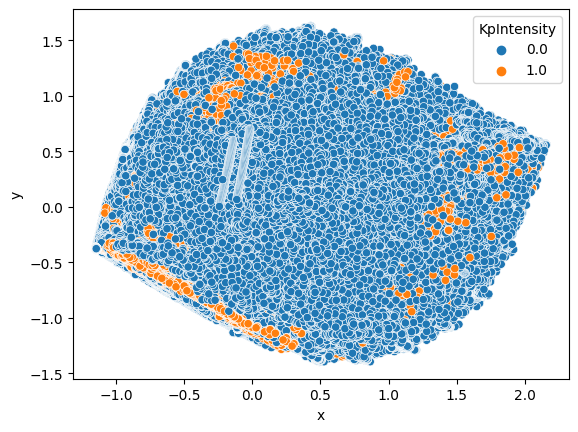

In [ ]:
pca = PCA(n_components=2)
to_visualize = pca.fit_transform(numpy.reshape(X_now, (X_now.shape[0]*X_now.shape[1], X_now.shape[2])))
to_visualize_df = pandas.DataFrame({'x': to_visualize[:,0], 'y': to_visualize[:,1], 'KpIntensity': numpy.repeat(y_now, 720)})
seaborn.scatterplot(to_visualize_df, x='x', y='y', hue='KpIntensity')

# Time Series Classification (Modeling With -15 to -3 Hours) - 2 PCAs

Useful resource: https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

In [ ]:
X = X_now
y = pandas.DataFrame({'next': y_next, 'now': y_now, 'prev_1': y_prev_1, 'prev_2': y_prev_2, 'prev_3': y_prev_3})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y['next'])

In [ ]:
X_train.shape

(11874, 720, 15)

In [ ]:
X_test.shape

(2969, 720, 15)

In [ ]:
pca = PCA(n_components=2)
X_train = numpy.reshape(pca.fit_transform(numpy.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2]))), (11874, 720, 2))
X_test = numpy.reshape(pca.transform(numpy.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_test.shape[2]))), (2969, 720, 2))

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train.shape[1:])

In [ ]:
numpy.unique(y_next, return_counts=True)

(array([0., 1.]), array([14515,   328]))

In [ ]:
14521/329

44.13677811550152

In [ ]:
329/14521

0.022656841815301976

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1),
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(X_train, y_train['next'], batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_split=0.2, verbose=1, class_weight={0: 1., 1: 45.})

Epoch 1/500
297/297 [==============================] - ETA: 0s - loss: 1.2511 - binary_accuracy: 0.6529

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


297/297 [==============================] - 54s 176ms/step - loss: 1.2511 - binary_accuracy: 0.6529 - val_loss: 0.3454 - val_binary_accuracy: 0.8838 - lr: 0.0010
Epoch 2/500
297/297 [==============================] - 49s 167ms/step - loss: 1.2167 - binary_accuracy: 0.6794 - val_loss: 0.4653 - val_binary_accuracy: 0.8438 - lr: 0.0010
Epoch 3/500
297/297 [==============================] - 50s 169ms/step - loss: 1.2080 - binary_accuracy: 0.6952 - val_loss: 0.6528 - val_binary_accuracy: 0.6358 - lr: 0.0010
Epoch 4/500
297/297 [==============================] - 50s 168ms/step - loss: 1.2178 - binary_accuracy: 0.6978 - val_loss: 0.6394 - val_binary_accuracy: 0.6425 - lr: 0.0010
Epoch 5/500
297/297 [==============================] - 49s 164ms/step - loss: 1.1955 - binary_accuracy: 0.6885 - val_loss: 0.7091 - val_binary_accuracy: 0.6539 - lr: 0.0010
Epoch 6/500
297/297 [==============================] - 53s 178ms/step - loss: 1.2102 - binary_accuracy: 0.6800 - val_loss: 0.5886 - val_binary_accu

In [ ]:
model = keras.models.load_model('best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test['next'])
print('Test accuracy', test_acc)
print('Test loss', test_loss)

93/93 [==============================] - 4s 43ms/step - loss: 0.3539 - binary_accuracy: 0.8750
Test accuracy 0.8750420808792114
Test loss 0.3538605272769928


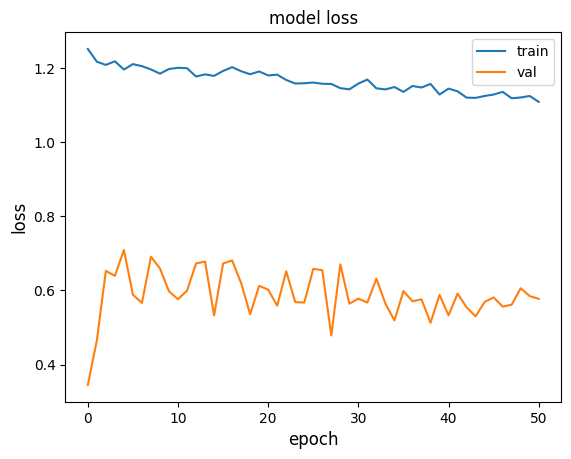

In [ ]:
metric = 'loss'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'val'], loc='best')
plt.show()
plt.close()

In [ ]:
probabilities = model.predict(X_test)
predictions = []
for probability in probabilities:
    if probability >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
print(confusion_matrix(y_test['next'], predictions))
print(classification_report(y_test['next'], predictions))
print('roc_auc_score:', roc_auc_score(y_test['next'], probabilities))
print('average_precision_score:', average_precision_score(y_test['next'], probabilities))

93/93 [==============================] - 4s 42ms/step
[[2574  329]
 [  42   24]]
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      2903
         1.0       0.07      0.36      0.11        66

    accuracy                           0.88      2969
   macro avg       0.53      0.63      0.52      2969
weighted avg       0.96      0.88      0.91      2969

roc_auc_score: 0.7765112370692805
average_precision_score: 0.0803663951741778


In [ ]:
probabilities_train = model.predict(X_train)
X_train_v2 = pandas.DataFrame({'next_probabilities': probabilities_train.flatten(), 'now': y_train['now'], 'prev_1': y_train['prev_1'], 'prev_2': y_train['prev_2'], 'prev_3': y_train['prev_3']})
X_test_v2 = pandas.DataFrame({'next_probabilities': probabilities.flatten(), 'now': y_test['now'], 'prev_1': y_test['prev_1'], 'prev_2': y_test['prev_2'], 'prev_3': y_test['prev_3']})

372/372 [==============================] - 15s 40ms/step


In [ ]:
clfs = {'SVC (linear)': SVC(kernel='linear', class_weight='balanced'),
        'SVC (rbf)': SVC(kernel='rbf', class_weight='balanced'),
        'Logistic regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Decision tree': DecisionTreeClassifier(class_weight='balanced'),
        'Random forest': RandomForestClassifier(class_weight='balanced'),
        'Gaussian Naive Bayes': GaussianNB(),
        'K nearest neighbors': KNeighborsClassifier(),
        'Multi-layer perceptron': MLPClassifier(max_iter=500),
        'Voting classifier 1': VotingClassifier(estimators=[('clf_1', LogisticRegression(max_iter=1000, class_weight='balanced')), ('clf_2', GaussianNB()), ('clf_3', MLPClassifier(max_iter=500)), ('clf_4', SVC(kernel='linear', class_weight='balanced', probability=True))], voting='soft'),
        'Voting classifier 2': VotingClassifier(estimators=[('clf_1', LogisticRegression(max_iter=1000, class_weight='balanced')), ('clf_2', GaussianNB()), ('clf_3', SVC(kernel='linear', class_weight='balanced', probability=True))], voting='hard'),
       }

for clf_name, clf in clfs.items():
    print(clf_name)
    clf.fit(X_train_v2, y_train['next'])
    clf.score(X_test_v2, y_test['next'])
    print(confusion_matrix(y_test['next'], clf.predict(X_test_v2)))
    print(classification_report(y_test['next'], clf.predict(X_test_v2)))
    print('roc_auc_score:', roc_auc_score(y_test['next'], clf.predict(X_test_v2)))
    print('average_precision_score:', average_precision_score(y_test['next'], clf.predict(X_test_v2)))
    print()

SVC (linear)
[[2763  140]
 [  19   47]]
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      2903
         1.0       0.25      0.71      0.37        66

    accuracy                           0.95      2969
   macro avg       0.62      0.83      0.67      2969
weighted avg       0.98      0.95      0.96      2969

roc_auc_score: 0.8319476194949843
average_precision_score: 0.18538179783436023

SVC (rbf)
[[2782  121]
 [  20   46]]
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      2903
         1.0       0.28      0.70      0.39        66

    accuracy                           0.95      2969
   macro avg       0.63      0.83      0.69      2969
weighted avg       0.98      0.95      0.96      2969

roc_auc_score: 0.8276443386674183
average_precision_score: 0.19871595184963062

Logistic regression
[[2544  359]
 [  13   53]]
              precision    recall  f1-score   support

       